<a href="https://colab.research.google.com/github/sgurudut/Auto-Tagging-Syatem-using-CNN/blob/main/auto_tagging_system_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Objective

Build a model to automatically predict tags for a given a StackExchange question by using the text of the question.
![alt text](https://cdn.sstatic.net/Sites/stackoverflow/company/img/logos/se/se-logo.svg?v=d29f0785ebb7)

__Dataset Specs__: Over 85,000 questions

[Download Link](https://www.kaggle.com/stackoverflow/statsquestions#Questions.csv)

# Steps to Follow



1. Load Data and Import Libraries
2. Text Cleaning
3. Merge Tags with Questions
4. Dataset Prepartion
5. Text Representation
6. Model Building
    1. Define Model Architecture
    2. Train the Model
7. Model Predictions
8. Model Evaluation
9. Inference



# Load Data and Import Libraries

In [2]:
!unzip '/content/drive/My Drive/Questions.csv.zip'

Archive:  /content/drive/My Drive/Questions.csv.zip
  inflating: Questions.csv           


In [3]:
!unzip '/content/drive/My Drive/Tags.csv.zip'

Archive:  /content/drive/My Drive/Tags.csv.zip
  inflating: Tags.csv                


In [4]:
#string matching
import re 

#reading files
import pandas as pd

#handling html data
from bs4 import BeautifulSoup

#visualization
import matplotlib.pyplot as plt  

pd.set_option('display.max_colwidth', 200)

In [5]:
# load the stackoverflow questions dataset
questions_df = pd.read_csv('Questions.csv',encoding='latin-1')

# load the tags dataset
tags_df = pd.read_csv('Tags.csv')

In [6]:
#print first 5 rows
questions_df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,6,5.0,2010-07-19T19:14:44Z,272,The Two Cultures: statistics vs. machine learning?,"<p>Last year, I read a blog post from <a href=""http://anyall.org/"">Brendan O'Connor</a> entitled <a href=""http://anyall.org/blog/2008/12/statistics-vs-machine-learning-fight/"">""Statistics vs. Mach..."
1,21,59.0,2010-07-19T19:24:36Z,4,Forecasting demographic census,<p>What are some of the ways to forecast demographic census with some validation and calibration techniques?</p>\n\n<p>Some of the concerns:</p>\n\n<ul>\n<li>Census blocks vary in sizes as rural\n...
2,22,66.0,2010-07-19T19:25:39Z,208,Bayesian and frequentist reasoning in plain English,<p>How would you describe in plain English the characteristics that distinguish Bayesian from Frequentist reasoning?</p>\n
3,31,13.0,2010-07-19T19:28:44Z,138,What is the meaning of p values and t values in statistical tests?,"<p>After taking a statistics course and then trying to help fellow students, I noticed one subject that inspires much head-desk banging is interpreting the results of statistical hypothesis tests...."
4,36,8.0,2010-07-19T19:31:47Z,58,Examples for teaching: Correlation does not mean causation,"<p>There is an old saying: ""Correlation does not mean causation"". When I teach, I tend to use the following standard examples to illustrate this point:</p>\n\n<ol>\n<li>number of storks and birth ..."


# Text Cleaning

Let's define a function to clean the text data.

In [7]:
def cleaner(text):

  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

In [8]:
# call preprocessing function
questions_df['cleaned_text'] = questions_df['Body'].apply(cleaner)

In [9]:
questions_df['Body'][1]

"<p>What are some of the ways to forecast demographic census with some validation and calibration techniques?</p>\n\n<p>Some of the concerns:</p>\n\n<ul>\n<li>Census blocks vary in sizes as rural\nareas are a lot larger than condensed\nurban areas. Is there a need to account for the area size difference?</li>\n<li>if let's say I have census data\ndating back to 4 - 5 census periods,\nhow far can i forecast it into the\nfuture?</li>\n<li>if some of the census zone change\nlightly in boundaries, how can i\naccount for that change?</li>\n<li>What are the methods to validate\ncensus forecasts? for example, if i\nhave data for existing 5 census\nperiods, should I model the first 3\nand test it on the latter two? or is\nthere another way?</li>\n<li>what's the state of practice in\nforecasting census data, and what are\nsome of the state of the art methods?</li>\n</ul>\n"

In [10]:
questions_df['cleaned_text'][1]

'what are some of the ways to forecast demographic census with some validation and calibration techniques some of the concerns census blocks vary in sizes as rural areas are a lot larger than condensed urban areas is there a need to account for the area size difference if let s say i have census data dating back to census periods how far can i forecast it into the future if some of the census zone change lightly in boundaries how can i account for that change what are the methods to validate census forecasts for example if i have data for existing census periods should i model the first and test it on the latter two or is there another way what s the state of practice in forecasting census data and what are some of the state of the art methods'

# Merge Tags with Questions

Let's now explore the tags data.

In [11]:
tags_df.head()

,Id,Tag
0,1,bayesian
1,1,prior
2,1,elicitation
3,2,distributions
4,2,normality


In [12]:
# count of unique tags
len(tags_df['Tag'].unique())

1315

In [13]:
tags_df['Tag'].value_counts()

r                       13236
regression              10959
machine-learning         6089
time-series              5559
probability              4217
                        ...  
fmincon                     1
doc2vec                     1
sympy                       1
adversarial-boosting        1
corpus-linguistics          1
Name: Tag, Length: 1315, dtype: int64

In [14]:
# remove "-" from the tags
tags_df['Tag']= tags_df['Tag'].apply(lambda x:re.sub("-"," ",x))

In [15]:
# group tags Id wise
tags_df = tags_df.groupby('Id').apply(lambda x:x['Tag'].values).reset_index(name='tags')
tags_df.head()

,Id,tags
0,1,"[bayesian, prior, elicitation]"
1,2,"[distributions, normality]"
2,3,"[software, open source]"
3,4,"[distributions, statistical significance]"
4,6,[machine learning]


In [16]:
# merge tags and questions
df = pd.merge(questions_df,tags_df,how='inner',on='Id')

In [17]:
df = df[['Id','Body','cleaned_text','tags']]
df.head()

,Id,Body,cleaned_text,tags
0,6,"<p>Last year, I read a blog post from <a href=""http://anyall.org/"">Brendan O'Connor</a> entitled <a href=""http://anyall.org/blog/2008/12/statistics-vs-machine-learning-fight/"">""Statistics vs. Mach...",last year i read a blog post from brendan o connor entitled statistics vs machine learning fight that discussed some of the differences between the two fields andrew gelman responded favorably to ...,[machine learning]
1,21,<p>What are some of the ways to forecast demographic census with some validation and calibration techniques?</p>\n\n<p>Some of the concerns:</p>\n\n<ul>\n<li>Census blocks vary in sizes as rural\n...,what are some of the ways to forecast demographic census with some validation and calibration techniques some of the concerns census blocks vary in sizes as rural areas are a lot larger than conde...,"[forecasting, population, census]"
2,22,<p>How would you describe in plain English the characteristics that distinguish Bayesian from Frequentist reasoning?</p>\n,how would you describe in plain english the characteristics that distinguish bayesian from frequentist reasoning,"[bayesian, frequentist]"
3,31,"<p>After taking a statistics course and then trying to help fellow students, I noticed one subject that inspires much head-desk banging is interpreting the results of statistical hypothesis tests....",after taking a statistics course and then trying to help fellow students i noticed one subject that inspires much head desk banging is interpreting the results of statistical hypothesis tests it s...,"[hypothesis testing, t test, p value, interpretation, intuition]"
4,36,"<p>There is an old saying: ""Correlation does not mean causation"". When I teach, I tend to use the following standard examples to illustrate this point:</p>\n\n<ol>\n<li>number of storks and birth ...",there is an old saying correlation does not mean causation when i teach i tend to use the following standard examples to illustrate this point number of storks and birth rate in denmark number of ...,"[correlation, teaching]"


In [18]:
df.shape

(85085, 4)

There are over 85,000 unique questions and over 1300 tags.

# Dataset Preparation

In [19]:
# check frequency of occurence of each tag
freq= {}
for i in df['tags']:
  for j in i:
    if j in freq.keys():
      freq[j] = freq[j] + 1
    else:
      freq[j] = 1

Let's find out the most frequent tags.

In [20]:
# sort the dictionary in descending order
freq = dict(sorted(freq.items(), key=lambda x:x[1],reverse=True))

In [21]:
freq.items()

dict_items([('r', 13236), ('regression', 10959), ('machine learning', 6089), ('time series', 5559), ('probability', 4217), ('hypothesis testing', 3869), ('self study', 3732), ('distributions', 3501), ('logistic', 3316), ('classification', 2881), ('correlation', 2871), ('statistical significance', 2666), ('bayesian', 2656), ('anova', 2505), ('normal distribution', 2181), ('multiple regression', 2054), ('mixed model', 1998), ('clustering', 1952), ('neural networks', 1897), ('mathematical statistics', 1888), ('confidence interval', 1776), ('categorical data', 1703), ('generalized linear model', 1614), ('variance', 1576), ('data visualization', 1549), ('estimation', 1533), ('forecasting', 1422), ('t test', 1418), ('pca', 1395), ('sampling', 1363), ('cross validation', 1344), ('repeated measures', 1335), ('spss', 1296), ('svm', 1283), ('chi squared', 1261), ('maximum likelihood', 1209), ('predictive models', 1189), ('multivariate analysis', 1116), ('survival', 1081), ('references', 1076), (

In [22]:
# Top 10 most frequent tags
common_tags = list(freq.keys())[:10]
common_tags

['r',
 'regression',
 'machine learning',
 'time series',
 'probability',
 'hypothesis testing',
 'self study',
 'distributions',
 'logistic',
 'classification']

We will use only those questions/queries that have the above 10 tags associated with it.

In [23]:
x=[]
y=[]

for i in range(len(df['tags'])):
  
  temp=[]
  for j in df['tags'][i]:
    if j in common_tags:
      temp.append(j)

  if(len(temp)>1):
    x.append(df['cleaned_text'][i])
    y.append(temp)

In [24]:
# number of questions left
len(x)

11106

In [25]:
y[:10]

[['r', 'time series'],
 ['regression', 'distributions'],
 ['distributions', 'probability', 'hypothesis testing'],
 ['hypothesis testing', 'self study'],
 ['r', 'regression', 'time series'],
 ['r', 'time series', 'self study'],
 ['probability', 'hypothesis testing'],
 ['r', 'regression'],
 ['r', 'regression'],
 ['regression', 'logistic']]

Now we will find a suitable sequence length.

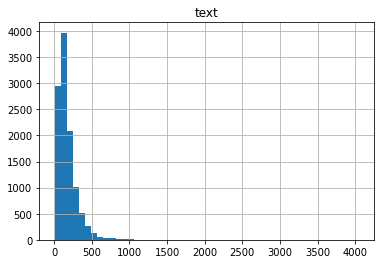

In [26]:
# populate the list with length of the questions
text_word_count = [len(i.split()) for i in x]

length_df = pd.DataFrame({'text':text_word_count})

#plot histogram
length_df.hist(bins=50)
plt.show()

In [27]:
#define threshold for maximum length of a setence
max_len=100

We will the input sequences to our model to the length of 100

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
y = mlb.fit_transform(y)
y.shape

(11106, 10)

In [29]:
y[0,:]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1])

In [30]:
mlb.classes_

array(['classification', 'distributions', 'hypothesis testing',
       'logistic', 'machine learning', 'probability', 'r', 'regression',
       'self study', 'time series'], dtype=object)

We can now split the dataset into training set and validation set. 

In [31]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(x, y, test_size=0.2, random_state=0,shuffle=True)

# Text Representation

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 

#prepare a tokenizer
x_tokenizer = Tokenizer() 

#prepare vocabulary
x_tokenizer.fit_on_texts(x_tr)

In [33]:
x_tokenizer.word_index

{'the': 1,
 'i': 2,
 'to': 3,
 'a': 4,
 'of': 5,
 'is': 6,
 'and': 7,
 'in': 8,
 'l': 9,
 'x': 10,
 'for': 11,
 'that': 12,
 'data': 13,
 'this': 14,
 't': 15,
 'have': 16,
 'y': 17,
 'with': 18,
 'model': 19,
 'it': 20,
 'are': 21,
 'be': 22,
 'my': 23,
 'as': 24,
 'on': 25,
 'e': 26,
 'p': 27,
 'if': 28,
 'can': 29,
 'n': 30,
 'but': 31,
 'not': 32,
 'm': 33,
 'or': 34,
 'r': 35,
 'how': 36,
 'regression': 37,
 'c': 38,
 'am': 39,
 's': 40,
 'from': 41,
 'test': 42,
 'what': 43,
 'would': 44,
 'b': 45,
 'so': 46,
 'time': 47,
 'there': 48,
 'using': 49,
 'which': 50,
 'an': 51,
 'do': 52,
 'one': 53,
 'each': 54,
 'value': 55,
 'use': 56,
 'by': 57,
 'some': 58,
 'variables': 59,
 'like': 60,
 'variable': 61,
 'we': 62,
 'at': 63,
 'na': 64,
 'any': 65,
 'f': 66,
 'distribution': 67,
 'two': 68,
 'values': 69,
 'set': 70,
 'you': 71,
 'all': 72,
 'function': 73,
 'fit': 74,
 'd': 75,
 'beta': 76,
 'question': 77,
 'then': 78,
 'mean': 79,
 'me': 80,
 'know': 81,
 'where': 82,
 'when'

In [34]:
len(x_tokenizer.word_index)

25312

There are around 25,000 tokens in the training dataset. Let's see how many tokens appear at least 5 times in the dataset.

In [35]:
thresh = 3

cnt=0
for key,value in x_tokenizer.word_counts.items():
  if value>=thresh:
    cnt=cnt+1

print(cnt)

12574


Over 12,000 tokens have appeared three times or more in the training set.

In [36]:
# prepare the tokenizer again
x_tokenizer = Tokenizer(num_words=cnt,oov_token='unk')

#prepare vocabulary
x_tokenizer.fit_on_texts(x_tr)

Now that we have encoded every token to an integer, let's convert the text sequences to integer sequences. After that we will pad the integer sequences to the maximum sequence length, i.e., 100.

In [37]:
#convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

#padding up with zero 
x_tr_seq = pad_sequences(x_tr_seq,  padding='post', maxlen=max_len)
x_val_seq = pad_sequences(x_val_seq, padding='post', maxlen=max_len)

Since we are padding the sequences with zeros, we must increment the vocabulary size by one.

In [38]:
#no. of unique words
x_voc_size = x_tokenizer.num_words + 1
x_voc_size

12575

In [39]:
x_tr_seq[0]

array([1953, 5711,  416, 2023,    1,  226, 1747, 3740,  609,   43,  181,
       1953,  372,   19,  100,  416,    9, 1747, 3839,  238,   27,   27,
         27,   27,   27,   70,    6, 6919,    8, 1163,   70,    6,   43,
         43, 1802, 1802, 1802,   36,   36,   36,   36, 4308, 5410,    4,
        124,  592,  107,   22,    2, 1747, 4065,   27,   10, 1309,   10,
       6414,   10,  190,   10,  416,   10,   27,   10, 1309,   10, 6414,
         10,  190,   10,  416,   10,  456,  139,   15,    7,    2, 4610,
        164,   27,   10, 1309,   10, 6414,   10,  190,   10,  416,   10,
         27,   76,   27, 1309,   76,   27, 6414,   76,   27,  190,   76,
         27], dtype=int32)

# Model Building

In [44]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
import keras.backend as K

### Define Model Architecture

In [45]:
# define model architecture
K.clear_session()
model =  Sequential()
model.add(Embedding(x_voc_size, 50, trainable=True, input_shape=(max_len,)))  #embedding layer
  
model.add(Conv1D(64,3,padding='same'))  #conv1d layer
model.add(Dropout(0.1))

model.add(GlobalMaxPooling1D()) 
  
model.add(Dense(128,activation='relu'))  #dense layer

model.add(Dense(10,activation='sigmoid')) #output layer
model.summary() #summary) of model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           628750    
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           9664      
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           628750    
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           9664      
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [47]:
#define optimizer and loss
model.compile(optimizer='adam',loss='binary_crossentropy')

#checkpoint to save best model during training
mc = ModelCheckpoint("weights.best.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

### Train the Model

In [48]:
#train the model 
model.fit(x_tr_seq, y_tr, batch_size=128, epochs=10, verbose=1, validation_data=(x_val_seq, y_val), callbacks=[mc])

Epoch 1/10
70/70 [==============================] - ETA: 0s - loss: 0.5353
Epoch 1: val_loss improved from inf to 0.47348, saving model to weights.best.hdf5
70/70 [==============================] - 13s 11ms/step - loss: 0.5353 - val_loss: 0.4735
Epoch 2/10
64/70 [==========================>...] - ETA: 0s - loss: 0.4375
Epoch 2: val_loss improved from 0.47348 to 0.37929, saving model to weights.best.hdf5
70/70 [==============================] - 0s 5ms/step - loss: 0.4340 - val_loss: 0.3793
Epoch 3/10
64/70 [==========================>...] - ETA: 0s - loss: 0.3313
Epoch 3: val_loss improved from 0.37929 to 0.30186, saving model to weights.best.hdf5
70/70 [==============================] - 0s 6ms/step - loss: 0.3296 - val_loss: 0.3019
Epoch 4/10
63/70 [==========================>...] - ETA: 0s - loss: 0.2787
Epoch 4: val_loss improved from 0.30186 to 0.27901, saving model to weights.best.hdf5
70/70 [==============================] - 0s 6ms/step - loss: 0.2778 - val_loss: 0.2790
Epoch 5/10

# Model Predictions 

In [49]:
# load weights into new model
model.load_weights("weights.best.hdf5")

#predict probabilities
pred_prob = model.predict(x_val_seq)

In [50]:
pred_prob[0]

array([0.04582438, 0.09284852, 0.03546676, 0.02876706, 0.12024416,
       0.03897842, 0.96568733, 0.16157053, 0.032529  , 0.09553099],
      dtype=float32)

The predictions are in terms of probabilities for each of the 10 tags. Hence we need to have a threshold value to convert these probabilities to 0 or 1.

Let's specify a set of candidate threshold values. We will select the threshold value that performs the best for the validation set.

In [51]:
#define candidate threshold values
threshold  = np.arange(0,0.5,0.01)
threshold

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49])

Let's define a function that takes a threshold value and uses it to convert probabilities into 1 or 0.

In [52]:
# convert probabilities into classes or tags based on a threshold value
def classify(pred_prob,thresh):
  y_pred_seq = []

  for i in pred_prob:
    temp=[]
    for j in i:
      if j>=thresh:
        temp.append(1)
      else:
        temp.append(0)
    y_pred_seq.append(temp)

  return y_pred_seq

In [53]:
from sklearn import metrics
score=[]

#convert to 1 array
y_true = np.array(y_val).ravel() 

for thresh in threshold:
    
    #classes for each threshold
    y_pred_seq = classify(pred_prob,thresh) 

    #convert to 1d array
    y_pred = np.array(y_pred_seq).ravel()

    score.append(metrics.f1_score(y_true,y_pred))

In [54]:
# find the optimal threshold
opt = threshold[score.index(max(score))]
opt

0.36

# Model Evaluation

In [55]:
#predictions for optimal threshold
y_pred_seq = classify(pred_prob,opt)
y_pred = np.array(y_pred_seq).ravel()

In [56]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     17520
           1       0.73      0.75      0.74      4700

    accuracy                           0.89     22220
   macro avg       0.83      0.84      0.83     22220
weighted avg       0.89      0.89      0.89     22220



In [57]:
y_pred = mlb.inverse_transform(np.array(y_pred_seq))
y_true = mlb.inverse_transform(np.array(y_val))

df = pd.DataFrame({'comment':x_val,'actual':y_true,'predictions':y_pred})

In [58]:
df.sample(10)

,comment,actual,predictions
939,i have a time series prediction problem where the aim is to forecast the average value of y t over the next t periods given all the information available up to point t for example i want to foreca...,"(machine learning, time series)","(machine learning,)"
233,is there a standard way to report the percent correctly predicted when predicting a binary outcome using glm in r the results are predicted probabilities however in order to make a comparison to a...,"(logistic, r)","(logistic, r, regression)"
1766,consider this example foo data frame x c y c model lm y poly x data foo model lm y poly x data foo for model the poly x term is not significant summary model call lm formula y poly x data foo resi...,"(r, regression)","(hypothesis testing, regression)"
2147,i ve sampled variables from a gauss distribution with mean and standard deviation set seed wn rnorm then i ve fitted an ar model with the arima command and sent the results to the wnf variable wnf...,"(r, time series)","(r, regression)"
1266,crossvalidated community i must mention that i am a first time poster and relatively new to both modelling and r so please excuse any norms i may violate in my post and politely inform me i have b...,"(logistic, r)","(logistic, r, regression)"
1681,if y is a random variable defined as y g x x where x and x are two different random variables whose distributions are known say with pdf s f x and f x how do we find the distribution of y i e the ...,"(distributions, probability, self study)","(distributions, probability)"
597,i have a homework assignment about implementing the adaboost algorithm we are following this article by schapire i m not exactly sure what they mean in the assignment by let the training patterns ...,"(classification, self study)","(distributions, machine learning)"
951,in the game of poker how do we test h o textrm winrate or how can we test h o textrm winrate x for x in mathbb r winrate might be measured as the population profit per hand if we think of the aver...,"(hypothesis testing, probability)","(hypothesis testing, self study)"
1722,i create time series model via model sarima data sarima for data the model diagnostics look good and indicate that the model is a good fit however when i try to forecast the data all the forecaste...,"(r, time series)","(regression, time series)"
845,i have done binary logistic regression for a dichotomous outcome and used predictors continuous and dichotomous one of the dichotomous predictor gave a big number of or and ci ci p is such a big n...,"(logistic, regression)","(logistic, regression)"


# Inference

In [59]:
def predict_tag(comment):  
  text=[]

  #preprocess  
  text = [cleaner(comment)]

  #convert to integer sequences
  seq = x_tokenizer.texts_to_sequences(text)

  #pad the sequence
  pad_seq = pad_sequences(seq,  padding='post', maxlen=max_len)

  #make predictions
  pred_prob = model.predict(pad_seq)
  classes = classify(pred_prob,opt)[0]
  
  classes = np.array([classes])
  classes = mlb.inverse_transform(classes)  
  return classes

In [60]:
comment = "For example, in the case of logistic regression, the learning function is a Sigmoid function that tries to separate the 2 classes"

print("Comment:",comment)
print("Predicted Tags:",predict_tag(comment))

Comment: For example, in the case of logistic regression, the learning function is a Sigmoid function that tries to separate the 2 classes
Predicted Tags: [('classification', 'logistic', 'machine learning', 'regression')]
